# Process data (generate_dataset-9.py)

In [1]:
import pandas as pd
import os


# Load data
plavki_train = pd.read_csv('data/raw/plavki_train.csv', index_col='NPLV')
plavki_test = pd.read_csv('data/raw/plavki_test.csv', index_col='NPLV')


chugun_train  = pd.read_csv('data/raw/chugun_train.csv', index_col='NPLV')
chugun_test  = pd.read_csv('data/raw/chugun_test.csv', index_col='NPLV')
chugun_train = chugun_train.add_prefix('chugun_')
chugun_test = chugun_test.add_prefix('chugun_')

sip_train = pd.read_csv('data/raw/sip_train.csv')
sip_test = pd.read_csv('data/raw/sip_test.csv')



lom_train = pd.read_csv('data/raw/lom_train.csv')
lom_test = pd.read_csv('data/raw/lom_test.csv')

produv_train = pd.read_csv('data/raw/produv_train.csv')
produv_test = pd.read_csv('data/raw/produv_test.csv')



target_train = pd.read_csv('data/raw/target_train.csv', index_col='NPLV')

sample_submission = pd.read_csv('data/raw/sample_submission.csv', index_col='NPLV')


# drop many plavk
mask = (plavki_train.index == 511135) & (plavki_train['plavka_ST_FURM'] != 46)
plavki_train = plavki_train[~mask]

# lom
lom_train = lom_train.drop(columns='NML')
lom_test = lom_test.drop(columns='NML')

lom_train = pd.pivot(lom_train, index='NPLV', columns='VDL', values='VES').fillna(0).astype(int).add_prefix('lom_VES_VLD')
lom_test = pd.pivot(lom_test, index='NPLV', columns='VDL', values='VES').fillna(0).astype(int).add_prefix('lom_VES_VLD')

lom_train['lom_components'] = lom_train.apply(lambda x: (x > 0).sum(), axis=1)
lom_test['lom_components'] = lom_test.apply(lambda x: (x > 0).sum(), axis=1)

lom_train['lom_VES_sum'] = lom_train[[x for x in lom_train.columns if x.startswith('lom_VES_VLD')]].apply(lambda x: x.sum(), axis=1)

lom_test['lom_VES_sum'] = lom_test[[x for x in lom_test.columns if x.startswith('lom_VES_VLD')]].apply(lambda x: x.sum(), axis=1)





# remove 1 column
lom_train = lom_train[lom_test.columns]

# sip
sip_train = sip_train.drop(columns=['NMSYP', 'DAT_OTD'])
sip_test = sip_test.drop(columns=['NMSYP', 'DAT_OTD'])
sip_train = sip_train.groupby(['NPLV', 'VDSYP'])['VSSYP'].sum().reset_index()
sip_test = sip_test.groupby(['NPLV', 'VDSYP'])['VSSYP'].sum().reset_index()
sip_train = pd.pivot(sip_train, index='NPLV', columns='VDSYP', values='VSSYP').fillna(0).astype(int).add_prefix('sip_VES_VDSYP')
sip_test = pd.pivot(sip_test, index='NPLV', columns='VDSYP', values='VSSYP').fillna(0).astype(int).add_prefix('sip_VES_VDSYP')
# Remove columns
sip_test = sip_test[sip_train.columns]

sip_train['sip_components'] = sip_train.apply(lambda x: (x > 0).sum(), axis=1)
sip_test['sip_components'] = sip_test.apply(lambda x: (x > 0).sum(), axis=1)


# produv_train
min_pol_train = produv_train.groupby('NPLV')['POL'].min().to_frame().add_prefix('produv_min_')
mean_pol_train = produv_train.groupby('NPLV')['POL'].mean().to_frame().add_prefix('produv_mean_')
max_pol_train = produv_train.groupby('NPLV')['POL'].max().to_frame().add_prefix('produv_max_')

min_pol_test = produv_test.groupby('NPLV')['POL'].min().to_frame().add_prefix('produv_min_')
mean_pol_test = produv_test.groupby('NPLV')['POL'].mean().to_frame().add_prefix('produv_mean_')
max_pol_test = produv_test.groupby('NPLV')['POL'].max().to_frame().add_prefix('produv_max_')

ras_train = produv_train.groupby('NPLV')['RAS'].sum().to_frame().add_prefix('produv_sum_')
ras_test = produv_test.groupby('NPLV')['RAS'].sum().to_frame().add_prefix('produv_sum_')

ras_train_mean = produv_train.groupby('NPLV')['RAS'].mean().to_frame().add_prefix('produv_mean_')
ras_test_mean = produv_test.groupby('NPLV')['RAS'].mean().to_frame().add_prefix('produv_mean_')

produv_train_groupped = pd.concat([max_pol_train, mean_pol_train, min_pol_train, ras_train_mean, ras_train], axis=1)
produv_test_groupped = pd.concat([max_pol_test, mean_pol_test, min_pol_test, ras_test_mean, ras_test], axis=1)



#########################
chronom_train = pd.read_csv('data/raw/chronom_train.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])
chronom_test = pd.read_csv('data/raw/chronom_test.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])
gas_train = pd.read_csv('data/raw/gas_train.csv')
gas_test = pd.read_csv('data/raw/gas_test.csv')

# train
chronom_povalka_start_train = chronom_train[chronom_train['NOP']=='Продувка'].groupby('NPLV')['VR_KON'].max()
chronom_povalka_start_train.columns = ['chronom_povalka_start']
chronom_produvka_start_train = chronom_train[chronom_train['NOP']=='Продувка'].groupby('NPLV')['VR_NACH'].min()
chronom_produvka_start_train.columns = ['chronom_produvka_start']

chronom__df_train = pd.merge(chronom_povalka_start_train,chronom_produvka_start_train, on='NPLV')
chronom__df_train.columns = ['chronom_povalka_start', 'chronom_produvka_start']

gas_train['Time'] = pd.to_datetime(gas_train['Time'])
gas_train = gas_train.set_index(gas_train['Time'])

data = []
for n in chronom__df_train.index:
    idx = gas_train[gas_train['NPLV']==n].index.get_loc(chronom__df_train.loc[n]['chronom_povalka_start'], method='nearest')
    ___df = gas_train[gas_train['NPLV']==n].iloc[idx]
    data.append([___df['NPLV'],___df['T']])
    
temp_gaz_train = pd.DataFrame(data, columns=['NPLV','gas_T_start_povalka'])

#test
chronom_povalka_start_test = chronom_test[chronom_test['NOP']=='Продувка'].groupby('NPLV')['VR_KON'].max()
chronom_povalka_start_test.columns = ['chronom_povalka_start']
chronom_produvka_start_test = chronom_test[chronom_test['NOP']=='Продувка'].groupby('NPLV')['VR_NACH'].min()
chronom_produvka_start_test.columns = ['chronom_produvka_start']

chronom__df_test = pd.merge(chronom_povalka_start_test,chronom_produvka_start_test, on='NPLV')
chronom__df_test.columns = ['chronom_povalka_start', 'chronom_produvka_start']

gas_test['Time'] = pd.to_datetime(gas_test['Time'])
gas_test = gas_test.set_index(gas_test['Time'])

data = []
for n in chronom__df_test.index:
    idx = gas_test[gas_test['NPLV']==n].index.get_loc(chronom__df_test.loc[n]['chronom_povalka_start'], method='nearest')
    ___df = gas_test[gas_test['NPLV']==n].iloc[idx]
    data.append([___df['NPLV'],___df['T']])
    
temp_gaz_test = pd.DataFrame(data, columns=['NPLV','gas_T_start_povalka'])






## chronom_train
chronom_train = pd.read_csv('data/raw/chronom_train.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])
chronom_test = pd.read_csv('data/raw/chronom_test.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])




chronom_train['operation_time'] = (chronom_train['VR_KON'] - chronom_train['VR_NACH']).dt.total_seconds()
chronom_test['operation_time'] = (chronom_test['VR_KON'] - chronom_test['VR_NACH']).dt.total_seconds()

chronom_train = chronom_train.groupby(['NPLV', 'NOP'])['operation_time'].mean().reset_index()
chronom_test = chronom_test.groupby(['NPLV', 'NOP'])['operation_time'].mean().reset_index()

chronom_train = pd.pivot(chronom_train, index='NPLV', columns='NOP', values='operation_time').fillna(0).astype(int)
chronom_test = pd.pivot(chronom_test, index='NPLV', columns='NOP', values='operation_time').fillna(0).astype(int)

common_columns = [x for x in chronom_test.columns if x in chronom_train.columns]

chronom_train = chronom_train[common_columns]
chronom_test = chronom_test[common_columns]

chronom_train = chronom_train.add_prefix('chronom_time_')
chronom_test = chronom_test.add_prefix('chronom_time_')










# gas_train



gas_train = pd.read_csv('data/raw/gas_train.csv')
gas_test = pd.read_csv('data/raw/gas_test.csv')


gas_train = gas_train.drop(columns='Time')
gas_test = gas_test.drop(columns='Time')

# gas_train[['V_O2','V_N2','V_H2','V_CO2','V_CO','V_AR']] = gas_train[['O2','N2','H2','CO2','CO','AR']]*gas_train['V']
# gas_test[['V_O2','V_N2','V_H2','V_CO2','V_CO','V_AR']] = gas_test[['O2','N2','H2','CO2','CO','AR']]*gas_train['V']



_gas_train = gas_train.groupby(['NPLV']).agg(
    {
        'V':['mean', 'sum'],
        'T':['mean','sum','max'],
        'O2':['mean', 'sum'],
        'N2':['mean', 'sum'],
        'H2':['mean', 'sum'],
        'CO2':['mean', 'sum'],
        'CO':['mean', 'sum'],
        'AR':['mean', 'sum'],
        'T фурмы 1':['mean', 'sum'],
        'T фурмы 2':['mean', 'sum'],
        'O2_pressure':['mean', 'sum'],
    })
_gas_train.columns = ["_".join(x) for x in _gas_train.columns.ravel()]

_gas_test = gas_test.groupby(['NPLV']).agg(
    {
        'V':['mean', 'sum'],
        'T':['mean','sum','max'],
        'O2':['mean', 'sum'],
        'N2':['mean', 'sum'],
        'H2':['mean', 'sum'],
        'CO2':['mean', 'sum'],
        'CO':['mean', 'sum'],
        'AR':['mean', 'sum'],
        'T фурмы 1':['mean', 'sum'],
        'T фурмы 2':['mean', 'sum'],
        'O2_pressure':['mean', 'sum'],
    })
_gas_test.columns = ["_".join(x) for x in _gas_test.columns.ravel()]


gas_train = _gas_train.add_prefix('gas_')
gas_test = _gas_test.add_prefix('gas_')



# Merge
train = pd.merge(target_train, chugun_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, plavki_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, lom_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, sip_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, produv_train_groupped, left_index=True, right_index=True, how='outer')
train = pd.merge(train, gas_train, left_index=True, right_index=True, how='outer')
train = pd.merge(train, chronom_train, left_index=True, right_index=True, how='outer')

train = pd.merge(train, temp_gaz_train.set_index('NPLV'), left_index=True, right_index=True, how='outer')

print("Nas:", train.isna().sum().sum())
print("Shape:", train.shape)

test = pd.merge(sample_submission, chugun_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, plavki_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, lom_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, sip_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, produv_test_groupped, left_index=True, right_index=True, how='outer')
test = pd.merge(test, gas_test, left_index=True, right_index=True, how='outer')
test = pd.merge(test, chronom_test, left_index=True, right_index=True, how='outer')

test = pd.merge(test, temp_gaz_test.set_index('NPLV'), left_index=True, right_index=True, how='outer')

print("Nas:", test.isna().sum().sum())
print("Shape:", test.shape)


# Feature generation
# train = pd.read_csv('data/processed/train.csv', parse_dates=['chugun_DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON']).dropna()
# test = pd.read_csv('data/processed/test.csv', parse_dates=['chugun_DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON'])

train['chugun_DATA_ZAMERA'] = pd.to_datetime(train['chugun_DATA_ZAMERA'])
train['plavka_VR_NACH'] = pd.to_datetime(train['plavka_VR_NACH'])
train['plavka_VR_KON'] = pd.to_datetime(train['plavka_VR_KON'])

test['chugun_DATA_ZAMERA'] = pd.to_datetime(test['chugun_DATA_ZAMERA'])
test['plavka_VR_NACH'] = pd.to_datetime(test['plavka_VR_NACH'])
test['plavka_VR_KON'] = pd.to_datetime(test['plavka_VR_KON'])

train['timer'] = (train['chugun_DATA_ZAMERA'] - train['plavka_VR_NACH']).dt.total_seconds()
test['timer'] = (test['chugun_DATA_ZAMERA'] - test['plavka_VR_NACH']).dt.total_seconds()

train['VES/O2'] = train['chugun_VES'] / train['gas_O2_sum']
test['VES/O2'] = test['chugun_VES'] / test['gas_O2_sum']


train = train.dropna()

train.to_csv('data/processed/train-2.csv')
test.to_csv('data/processed/test-2.csv')

print("Nas:", train.isna().sum().sum())
print("Shape:", train.shape)

C:\Users\Stepan\AppData\Local\Temp/ipykernel_1520/1211325147.py:206: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  _gas_train.columns = ["_".join(x) for x in _gas_train.columns.ravel()]
C:\Users\Stepan\AppData\Local\Temp/ipykernel_1520/1211325147.py:222: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  _gas_test.columns = ["_".join(x) for x in _gas_test.columns.ravel()]


Nas: 2
Shape: (2063, 98)
Nas: 0
Shape: (780, 98)
Nas: 0
Shape: (2061, 100)


# Библиотеки

In [1]:
# import dill
import sys
import pickle
import random
import numpy as np
import pandas as pd
import warnings
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostRegressor, Pool
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

sys.path.append('utils')
from common_utils import fast_plot, fast_hist, fast_legend, feature_snapshot, fast_scatter

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})  
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# Set a seed value
seed_value= 12321 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Загрузка данных

In [3]:
%%time
train = pd.read_csv('data/processed/train-2.csv', parse_dates=['chugun_DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON'])
test = pd.read_csv('data/processed/test-2.csv', parse_dates=['chugun_DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON'])

print('Train:', train.shape)
print('Test:', test.shape, '\n')

Train: (2061, 101)
Test: (780, 101) 

Wall time: 64 ms


In [4]:
chronom_train = pd.read_csv('data/raw/chronom_train.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])
chronom_test = pd.read_csv('data/raw/chronom_test.csv', index_col=0, parse_dates=['VR_NACH', 'VR_KON'])

def get_plavka_time_df(chronom):
    df = chronom.groupby('NPLV').apply(lambda x: x[x['NOP'] == 'Продувка'][['VR_NACH', 'VR_KON']])
    df = df.reset_index().drop(columns='level_1')
    
    return df

train_plavka_time = get_plavka_time_df(chronom_train)
test_plavka_time = get_plavka_time_df(chronom_test)

In [5]:
train = pd.merge(train, train_plavka_time, left_on='NPLV', right_on='NPLV')
test = pd.merge(test, test_plavka_time, left_on='NPLV', right_on='NPLV')

In [6]:
train['time_delta'] = (train['VR_KON'] - train['chugun_DATA_ZAMERA']).dt.total_seconds()
test['time_delta'] = (test['VR_KON'] - test['chugun_DATA_ZAMERA']).dt.total_seconds()

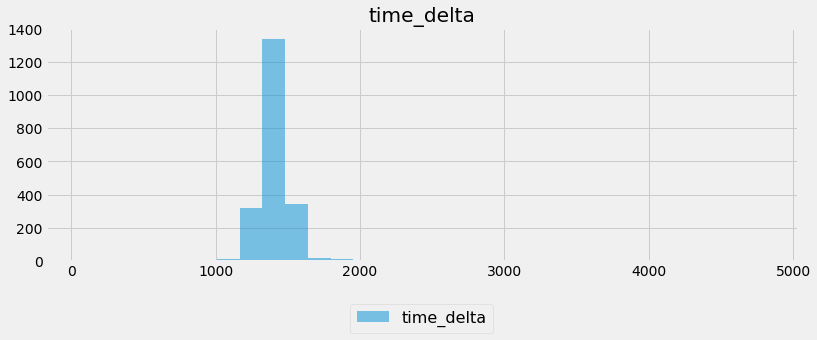

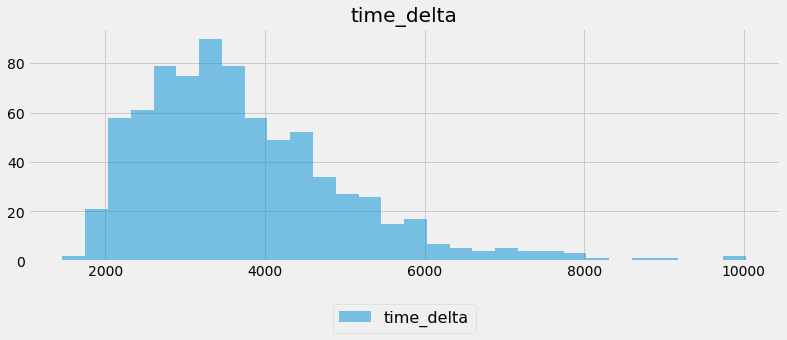

In [7]:
fast_hist(train['time_delta'])
fast_hist(test['time_delta'])

# Split

In [8]:
train = train.sort_values(['plavka_NMZ', 'TST', 'C', 'chronom_time_Продувка', 'gas_T_start_povalka',
                           'gas_O2_mean',  'plavka_NAPR_ZAD'])

In [9]:
train_idx = [x for x in range(train.shape[0]) if x%5 != 2]
val_idx = [x for x in range(train.shape[0]) if x%5 == 2] 

train_ = train.iloc[train_idx]
val_ = train.iloc[val_idx]

# Зоопарк моделей

In [10]:
class Model():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        
    def fit(self, X, y):  
        # pprint.pprint(self.params)
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

                
            # TODO (weight function!)
            train_dataset = Pool(data=X_train, label=y_train, **self.features_params)                
           
            model = CatBoostRegressor(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=y_val, **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self._feature_importance()
            
        
    def predict(self, X):        
        self.model_predictions = []
        for model_number in range(self.folds):
            model = self.models[model_number]
            self.model_predictions.append(model.predict(X))   
            
        self.predictions_summary = pd.DataFrame(data=np.array(self.model_predictions)).T
        
        self.predictions_summary['std'] = self.predictions_summary.std(axis=1)
        self.predictions_summary['predictions'] = (self.predictions_summary[[x for x in range(self.folds)]]).median(axis=1)
        self.predictions_summary['predictions2'] = (self.predictions_summary[[x for x in range(self.folds)]]).mean(axis=1) 
        self.predictions_summary['predictions_total'] = self.predictions_summary[['predictions', 'predictions2']].mean(axis=1)
                    
        return self.predictions_summary     
            
    def get_errors(self, X, y):   
        preds = self.predict(X)['predictions']
        errors = y.values - preds.values     
        return errors
    
    
    def interpretations():
        pass
    
    def uncertain_objects(std_treshold=1):
        pass    
   
    # New functions
    def _feature_importance(self):        
        
        for model_number in range(self.folds):
            fi_dict = list(zip(features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.models, f)
    
    def load_model(self, path):
        with open(path, 'rb') as f:
            self.models = pickle.load(f)

In [11]:
class LogModel():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        
    def fit(self, X, y):  
        # pprint.pprint(self.params)
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

                
            # TODO (weight function!)
            train_dataset = Pool(data=X_train, label=(y_train * 1000).apply(np.log1p), **self.features_params)                
           
            model = CatBoostRegressor(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=(y_val * 1000).apply(np.log1p), **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self._feature_importance()
            
        
    def predict(self, X):        
        self.model_predictions = []
        for model_number in range(self.folds):
            model = self.models[model_number]
            self.model_predictions.append(model.predict(X))                                     
                                    
        self.predictions_summary = pd.DataFrame(data=np.array(self.model_predictions)).T
        self.predictions_summary = np.e ** self.predictions_summary / 1000
        
        self.predictions_summary['std'] = self.predictions_summary.std(axis=1)
        self.predictions_summary['predictions'] = (self.predictions_summary[[x for x in range(self.folds)]]).median(axis=1)
        self.predictions_summary['predictions2'] = (self.predictions_summary[[x for x in range(self.folds)]]).mean(axis=1)
        
        
        second_predictions = pd.DataFrame(data=np.array(self.model_predictions)).T
        self.predictions_summary['predictions3'] = np.e ** (second_predictions[[x for x in range(self.folds)]]).median(axis=1) / 1000
        self.predictions_summary['predictions4'] = np.e ** (second_predictions[[x for x in range(self.folds)]]).mean(axis=1) / 1000
        self.predictions_summary['predictions_total'] = self.predictions_summary[['predictions', 'predictions2', 
                                                                                  'predictions3', 'predictions4']].mean(axis=1)
            
                    
        return self.predictions_summary     
            
    def get_errors(self, X, y):   
        preds = self.predict(X)['predictions']
        errors = y.values - preds.values     
        return errors
    
    
    def interpretations():
        pass
    
    def uncertain_objects(std_treshold=1):
        pass    
   
    # New functions
    def _feature_importance(self):        
        
        for model_number in range(self.folds):
            fi_dict = list(zip(features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.models, f)
    
    def load_model(self, path):
        with open(path, 'rb') as f:
            self.models = pickle.load(f)

In [12]:
class PowerTransformModel():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        
    def fit(self, X, y):  
        # pprint.pprint(self.params)
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

                
            # TODO (weight function!)
            self.transformer = PowerTransformer(method='box-cox')
            self.transformer.fit((y_train).values.reshape(1, -1).T)
            
            
            train_dataset = Pool(data=X_train, label=self.transformer.transform(y_train.values.reshape(1, -1).T)[:,0] , **self.features_params)                
           
            model = CatBoostRegressor(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=self.transformer.transform(y_val.values.reshape(1, -1).T)[:,0], **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self._feature_importance()
            
        
    def predict(self, X):        
        self.model_predictions = []
        for model_number in range(self.folds):
            model = self.models[model_number]
            self.model_predictions.append(self.transformer.inverse_transform(model.predict(X).reshape(1, -1).T)[:,0])                                     
                                    
        self.predictions_summary = pd.DataFrame(data=np.array(self.model_predictions)).T
        
        self.predictions_summary['std'] = self.predictions_summary.std(axis=1)
        self.predictions_summary['predictions'] = (self.predictions_summary[[x for x in range(self.folds)]]).median(axis=1)
        self.predictions_summary['predictions2'] = (self.predictions_summary[[x for x in range(self.folds)]]).mean(axis=1)
                    
        return self.predictions_summary     
            
    def get_errors(self, X, y):   
        preds = self.predict(X)['predictions']
        errors = y.values - preds.values     
        return errors
    
    
    def interpretations():
        pass
    
    def uncertain_objects(std_treshold=1):
        pass    
   
    # New functions
    def _feature_importance(self):        
        
        for model_number in range(self.folds):
            fi_dict = list(zip(features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.models, f)
    
    def load_model(self, path):
        with open(path, 'rb') as f:
            self.models = pickle.load(f)

In [13]:
class QuantileTransformModel():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        
    def fit(self, X, y):  
        # pprint.pprint(self.params)
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

                
            # TODO (weight function!)
            self.transformer = QuantileTransformer(n_quantiles=1000, random_state=0)
            self.transformer.fit((y_train).values.reshape(1, -1).T)
            
            
            train_dataset = Pool(data=X_train, label=self.transformer.transform(y_train.values.reshape(1, -1).T)[:,0] , 
                                 **self.features_params)                
           
            model = CatBoostRegressor(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=self.transformer.transform(y_val.values.reshape(1, -1).T)[:,0],
                                    **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self._feature_importance()
            
        
    def predict(self, X):        
        self.model_predictions = []
        for model_number in range(self.folds):
            model = self.models[model_number]
            self.model_predictions.append(self.transformer.inverse_transform(model.predict(X).reshape(1, -1).T)[:,0])                                     
                                    
        self.predictions_summary = pd.DataFrame(data=np.array(self.model_predictions)).T
        
        self.predictions_summary['std'] = self.predictions_summary.std(axis=1)
        self.predictions_summary['predictions'] = (self.predictions_summary[[x for x in range(self.folds)]]).median(axis=1)
        self.predictions_summary['predictions2'] = (self.predictions_summary[[x for x in range(self.folds)]]).mean(axis=1)  
                    
        return self.predictions_summary     
            
    def get_errors(self, X, y):   
        preds = self.predict(X)['predictions']
        errors = y.values - preds.values     
        return errors
    
    
    def interpretations():
        pass
    
    def uncertain_objects(std_treshold=1):
        pass    
   
    # New functions
    def _feature_importance(self):        
        
        for model_number in range(self.folds):
            fi_dict = list(zip(features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 
    
    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.models, f)
    
    def load_model(self, path):
        with open(path, 'rb') as f:
            self.models = pickle.load(f)

# Модель 1 (TST)

In [ ]:
train['gas_O2_pressure_mean']

In [24]:
target = 'TST'

not_features = ['NPLV', 'TST', 'C', 'chugun_DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON']
all_features = [x for x in train.columns if x not in not_features]


features = ['plavka_NMZ', 'chugun_VES', 'gas_CO2_sum', 'chronom_time_Продувка',
            'sip_VES_VDSYP408', 'gas_T_start_povalka', 'VES/O2', 'gas_O2_pressure_mean']
print('Features:', len(features))
train[all_features].head()

Features: 8


,chugun_VES,chugun_T,chugun_SI,chugun_MN,chugun_S,chugun_P,chugun_CR,chugun_NI,chugun_CU,chugun_V,chugun_TI,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL,lom_VES_VLD4,lom_VES_VLD8,lom_VES_VLD13,lom_VES_VLD20,lom_VES_VLD23,lom_VES_VLD48,lom_VES_VLD49,lom_VES_VLD61,lom_VES_VLD63,lom_components,lom_VES_sum,sip_VES_VDSYP104,sip_VES_VDSYP119,sip_VES_VDSYP171,sip_VES_VDSYP346,sip_VES_VDSYP397,sip_VES_VDSYP408,sip_VES_VDSYP442,sip_components,produv_max_POL,produv_mean_POL,produv_min_POL,produv_mean_RAS,produv_sum_RAS,gas_V_mean,gas_V_sum,gas_T_mean,gas_T_sum,gas_T_max,gas_O2_mean,gas_O2_sum,gas_N2_mean,gas_N2_sum,gas_H2_mean,gas_H2_sum,gas_CO2_mean,gas_CO2_sum,gas_CO_mean,gas_CO_sum,gas_AR_mean,gas_AR_sum,gas_T фурмы 1_mean,gas_T фурмы 1_sum,gas_T фурмы 2_mean,gas_T фурмы 2_sum,gas_O2_pressure_mean,gas_O2_pressure_sum,chronom_time_Вхождение в гр.МНЛЗ,chronom_time_Завалка лома,chronom_time_Заливка чугуна,chronom_time_Замена фурмы,chronom_time_Замер положения фурм,chronom_time_Наведение гарнисажа,chronom_time_Нагрев лома,chronom_time_Наложение продувки,chronom_time_Неиспр. АСУ и КИПиА,chronom_time_Неиспр. механ. обор.,chronom_time_Неиспр. электр. обор,chronom_time_Неиспр. энерг. обор,chronom_time_Обрыв горловины,chronom_time_Ожидание стальковша,chronom_time_Ожидание шл.чаш,chronom_time_Осмотр конвертера,chronom_time_Отсут. своб.разл.пл.,chronom_time_Отсутствие O2,chronom_time_Отсутствие мет.шихты,chronom_time_Отсутствие чугуна,chronom_time_ППР,chronom_time_Подварка футеровки,chronom_time_Полусухое торкрет.,chronom_time_Продувка,chronom_time_Ремонт летки,chronom_time_Слив шлака,chronom_time_межпл. простой,gas_T_start_povalka,timer,VES/O2,VR_NACH,VR_KON,time_delta
543,263600.0,1446.0,0.76,0.30,0.014,0.094,0.02,0.01,0.02,0.058,0.075,09Г2С,МНЛЗ,1590,цилиндрическая,20,5 сопловая,20,47900,11600,16000,0,0,0,0,0,0,3,75500,0,0,0,3570,0,19940,3670,3,6.53,4.506611,0.83,336.908757,1054187.5,212943.086853,6.396810e+08,449.462985,1.350187e+06,912.847229,9.772140,29355.508344,60.103475,180550.837709,0.500051,1502.152798,11.601286,34850.263867,17.141521,51493.129829,0.834024,2505.408724,18.375678,55200.536961,21.054180,63246.756812,15.390038,46231.674316,0,8,234,0,0,162,370,0,0,0,0,0,873,0,0,99,0,0,0,0,0,0,0,1106,0,101,1251,836.458313,384.0,8.979575,2021-01-31 16:57:56,2021-01-31 17:16:22,1337.0
786,266000.0,1395.0,0.39,0.24,0.012,0.084,0.02,0.01,0.02,0.086,0.077,09Г2С,МНЛЗ,1848,цилиндрическая,108,4-сопл х54,108,63300,12700,6000,0,0,0,0,0,0,3,82000,0,0,940,2140,0,13410,2920,4,6.15,4.132670,0.82,391.442901,901493.0,213127.252520,6.355455e+08,419.945944,1.252279e+06,829.513916,13.284018,39612.941082,59.478855,177365.944531,0.408998,1219.633158,9.705768,28942.599034,16.509641,49231.748427,0.789152,2353.250001,15.973331,47632.474018,19.701939,58751.183494,15.369207,45830.975959,0,234,305,0,0,223,388,0,0,0,0,0,0,0,0,158,0,0,0,0,0,0,0,1183,0,56,504,704.513855,686.0,6.714977,2021-02-14 08:01:38,2021-02-14 08:21:21,1486.0
1136,266500.0,1392.0,0.41,0.30,0.015,0.092,0.03,0.01,0.02,0.081,0.076,09Г2С,Изл,2247,цилиндрическая,39,4-сопл х54,161,77300,0,1000,0,0,0,0,0,0,2,78300,0,0,750,1150,0,11840,2980,4,4.77,3.200710,0.88,437.304565,699250.0,210957.260957,6.065021e+08,475.898539,1.368208e+06,884.375000,11.481250,33008.593014,62.679647,180203.986501,0.304461,875.324203,10.415759,29945.305978,14.376557,41332.600225,0.781535,2246.914057,20.798093,59794.516030,24.583300,70676.987805,15.418046,44326.882956,0,143,268,0,0,164,364,0,0,0,0,0,0,0,0,123,0,0,0,0,0,991,0,1274,0,49,938,720.138855,556.0,8.073655,2021-03-08 04:47:04,2021-03-08 05:08:18,1541.0
1778,265900.0,1407.0,0.83,0.34,0.013,0.118,0.03,0.01,0.02,0.069,0.061,09Г2С,МНЛЗ,2967,цилиндрическая,4,5 сопловая,4,25400,19900,0,0,11800,0,14800,0,0,4,71900,0,0,0,0,0,18980,2840,2,9.30,4.687707,1.00,418.718659,861723.0,222655.771691,7.886467e+08,375.823364,1.331166e+06,853.125000,10.563856,37417.177194,66.137776,234260.003758,0.497819,1763.275785,8.476269,30022.943028,13

In [25]:
cat_features = ['plavka_NMZ'] 

split_params = {'folds': 8}

model_params = {'eval_metric': 'RMSE', 
                'objective': 'RMSE', 
                'iterations':1500,
                'learning_rate':0.05,               
                'depth': 3, 
                'l2_leaf_reg': 50,  
                'one_hot_max_size': 15,
                'task_type': 'CPU',
                'has_time': False,
                'random_state': 20210926                
               }

train_params = {'early_stopping_rounds': 150, 
                'silent': True,
                'plot': True               
               }

gpu_params = {'devices': '0',
              'data_partition': 'DocParallel',
              'max_ctr_complexity': 4,
              'bootstrap_type': 'MVS',
              'border_count': 128, 
              'fold_permutation_block': 0,
              'simple_ctr':'FeatureFreq',
              'combinations_ctr': 'FeatureFreq',      
              'ctr_target_border_count': 1,
              'random_strength': 0.95,
              'gpu_ram_part': 0.95
             }


cpu_params = {'thread_count': 14}

features_params = {'cat_features': cat_features}

observations_params = {"weight": 'not_implemented'}

params = {'split_params': split_params, 
          'model_params': model_params, 
          'train_params': train_params, 
          'gpu_params': gpu_params, 
          'cpu_params': cpu_params, 
          'features_params': features_params, 
          'observations_params': observations_params
         }

In [26]:
%%time
ml1_original = Model(params)
ml1_original.fit(train_[features], train_[target])

preds1_original = ml1_original.predict(val_[features])

print('Metric:', np.round(((val_[target] - preds1_original['predictions'].values).abs()).mean(), 4))
print('Metric:', np.round(((val_[target] - preds1_original['predictions'].values).abs() < 20).mean(), 4))
print('Metric:', np.round(((val_[target] - preds1_original['predictions2'].values).abs() < 20).mean(), 4))


# Metric: 17.7215
# Metric: 0.6578
# Metric: 0.6505
# Wall time: 29.6 s


Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric: 19.1914
Metric: 0.6117
Metric: 0.6068
Wall time: 1min 6s


In [27]:
ml1_original.importance[0]

,importance
0,
VES/O2,30.867514
chronom_time_Продувка,23.946289
plavka_NMZ,20.994005
gas_T_start_povalka,10.657231
gas_CO2_sum,7.009435
chugun_VES,3.846620
gas_O2_pressure_mean,1.921614
sip_VES_VDSYP408,0.757291


In [28]:
%%time
ml1 = Model(params)
ml1.fit(train[features], train[target])

T_preds = ml1.predict(test[features])


Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 2s


In [29]:
T_preds['predictions']

0      1658.519542
1      1639.715627
2      1640.638367
3      1649.669051
4      1649.022853
          ...     
775    1653.914102
776    1648.901954
777    1641.123206
778    1659.408506
779    1662.752821
Name: predictions, Length: 780, dtype: float64

# Модель 2

In [31]:
train = train.sort_values(['plavka_NMZ', 'TST', 'C', 'chronom_time_Продувка',
                           'gas_O2_mean',  'plavka_NAPR_ZAD'])

In [32]:
target = 'C'
features = ['plavka_NMZ', 'chugun_VES', 'gas_CO2_sum', 'chronom_time_Продувка',
            'sip_VES_VDSYP408', 'gas_T_start_povalka', 'gas_O2_pressure_mean']
print(len(features))

7


In [33]:
cat_features = ['plavka_NMZ']

split_params = {'folds': 8}

model_params = {'eval_metric': 'RMSE', 
                'objective': 'RMSE',
                'iterations':2500,
                'learning_rate':0.05,               
                'depth': 3, 
                'l2_leaf_reg': 50,
                'one_hot_max_size': 30,
                'task_type': 'CPU',
                'has_time': False,
                'random_state': 20210926                
               }

train_params = {'early_stopping_rounds': 150, 
                'silent': True,
                'plot': True               
               }

gpu_params = {'devices': '0',
              'data_partition': 'DocParallel',
              'max_ctr_complexity': 4,
              'bootstrap_type': 'MVS',
              'border_count': 128, 
              'fold_permutation_block': 0,
              'simple_ctr':'FeatureFreq',
              'combinations_ctr': 'FeatureFreq',      
              'ctr_target_border_count': 1,
              'random_strength': 0.95,
              'gpu_ram_part': 0.95
             }


cpu_params = {'thread_count': 14}

features_params = {'cat_features': cat_features}


observations_params = {"weight": 'not_implemented'}

params = {'split_params': split_params, 
          'model_params': model_params, 
          'train_params': train_params, 
          'gpu_params': gpu_params, 
          'cpu_params': cpu_params, 
          'features_params': features_params, 
          'observations_params': observations_params
         }

In [34]:
%%time
ml2_quantile = QuantileTransformModel(params)
ml2_quantile.fit(train_[features], train_[target])

preds2_quantile = ml2_quantile.predict(val_[features])
print('Metric:', np.round(((val_[target] - preds2_quantile['predictions'].values).abs() < 0.02).mean(), 4))
print('Metric:', np.round(((val_[target] - preds2_quantile['predictions2'].values).abs() < 0.02).mean(), 4))

# Metric: 0.7354
# Metric: 0.7354
# Wall time: 22.7 s


Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric: 0.7476
Metric: 0.7451
Wall time: 1min 39s


In [35]:
ml2_quantile.importance[0]

,importance
0,
gas_T_start_povalka,52.511669
sip_VES_VDSYP408,13.470672
gas_CO2_sum,12.901034
chronom_time_Продувка,7.856676
plavka_NMZ,5.825459
chugun_VES,4.036281
gas_O2_pressure_mean,3.398208


# Submit

In [36]:
%%time
ml = QuantileTransformModel(params)
ml.fit(train[features], train[target])

C_preds = ml.predict(test[features])


Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 7


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 11s


In [37]:
test['TST'] = T_preds['predictions']
test['C'] = C_preds['predictions']

test[test.columns[:3]].to_csv('data/submissions/quantile_model_6.csv')
test[test.columns[:3]]

,NPLV,TST,C
0,512324,1658.519542,0.045500
1,512327,1639.715627,0.084000
2,512328,1640.638367,0.087500
3,512331,1649.669051,0.065531
4,512333,1649.022853,0.084000
...,...,...,...
775,513369,1653.914102,0.062000
776,513370,1648.901954,0.081290
777,513371,1641.123206,0.060477
778,513372,1659.408506,0.068000
